In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Conv1D, MaxPooling1D, Dropout, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import gensim

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
data_root = '/home/thenhz/workspace/hate-speech/data/'

GLOVE_MODEL_FILE = data_root + 'word2vec/glove_WIKI'


word2vec_model = gensim.models.Word2Vec.load(GLOVE_MODEL_FILE)
print("word2vec model loaded...")

word2vec model loaded...


In [3]:
from nltk.corpus import stopwords

nltk_stopwords = stopwords.words('italian')

data = pd.read_csv('data/hate-speech/haspeede_TW-train.tsv', sep='\t', names=['text','sentiment'])
print("data file loaded..")


FLAGS = re.MULTILINE | re.DOTALL

#preprocess

def preprocess_tweet(text, stopwords, FLAGS = FLAGS):
# Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    
    def hashtag(text):
        text = text.group()
        hashtag_body = text[1:]
        return hashtag_body
    
    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "")
    text = re_sub(r"/","")
    text = re_sub(r"@\w+", "")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<NHZSMILE>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<NHZLOLFACE>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<NHZSADFACE>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<NHZNEUTRALFACE>")
    text = re_sub(r"<3","<NHZ_HEART>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<NHZNUMBERS>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", "")
    #text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <NHZ_ELONG>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)
    
    #text = ''.join([c for c in text if c not in punctuation])
    
    #remove punctuation
    #text_no_punct = ''
    #for c in text:
    #    if c not in punctuation:
    #        text_no_punct += c
    #    else:
    #        text_no_punct += ' '
    #text = text_no_punct
    
    words = re.findall(r'[a-z]+', text.lower())
    text = ' '.join(words)
    
    
    #remove stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    
    return text


def filter_stop_words(train_sentences, stopwords):
    count = 0
    for i, sentence in train_sentences.iterrows():
        #print(sentence['text'])
        #if(count>10):
        #    break
        #count+=1
        new_sent = preprocess_tweet(sentence['text'],stopwords)
        #print(new_sent)
        #new_sent = ' '.join([word for word in new_sent.split() if word not in stop_words])
        #print(new_sent)
        train_sentences.set_value(i, 'text', new_sent, takeable=False)
    return train_sentences

train_sentences = filter_stop_words(data, nltk_stopwords)

data file loaded..


/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/site-packages/ipykernel_launcher.py:78: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [4]:
train_sentences

,text,sentiment
576268275560116224,invasione animali forse offesa animali stranie...,1
815833978691260416,terrorismo mettere stato soggezione persone re...,0
815112299044372480,infatti finch guadagnato campi rom ok alemanno...,0
577451440047853568,piovegovernolad italia stranieri culo va bene ...,1
844921803575382016,londonattack chiedete buonisti cavolo cosa vog...,1
811099342593462272,corriere tangenti mafia capitale dimenticatama...,0
833323806873833473,perch quando migranti israeliti arrivarono ter...,0
835493194796314624,divertimento giorno trovare patrioti italiani ...,0
839605324684361730,modena comune paga benzina nomadi portano figl...,0
851906322283016192,altro islam cristianesimo dobbiamo sorbire ign...,0


In [5]:
#data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 0].size) #positive
print(data[ data['sentiment'] == 1].size) #negative



4052
1944


In [6]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/site-packages/keras_preprocessing/text.py:175: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [7]:
len(tokenizer.word_index)

8353

In [8]:
word_vectors = word2vec_model.wv
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 100


In [9]:
len(word_vectors.vocab)

730613

In [10]:
from keras.wrappers.scikit_learn import KerasClassifier

# Embedding
max_features = 2000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(max_fatures, embedding_size) - 0.5) / 5.0
for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 
    
def create_model(scoring="accuracy"):  
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=X.shape[1],weights=[wv_matrix]))
    #model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

In [11]:
Y = np.array(data['sentiment'].values)
a = np.int8(np.logical_not(Y))
Y = np.vstack((Y,a)).T

In [13]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Y = data['sentiment'].values * .99

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.1)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

param_grid = {}#dict(epochs=[2,3,4])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,verbose=4)

grid_result = grid.fit(X_train, Y_train)



(2698, 21) (2698, 2)
(300, 21) (300, 2)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(
        [
            ('normalizer', StandardScaler()),
            ('select', SelectFromModel(RandomForestClassifier())),
            ('model', LogisticRegression(class_weight='balanced',penalty='l2'))
        ])

param_grid = {
    'select__estimator__n_estimators' : [5, 11, 19],
    'select__estimator__min_samples_split' : [2, 3, 4, 5]
}

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=4)

In [15]:
model = create_model()
model.fit(X_train, Y_train, epochs = epochs, validation_split = 0.1, batch_size=batch_size, verbose = 2)

Train on 2428 samples, validate on 270 samples
Epoch 1/2
 - 2s - loss: 0.6004 - acc: 0.6775 - val_loss: 0.5662 - val_acc: 0.6889
Epoch 2/2
 - 1s - loss: 0.4046 - acc: 0.8266 - val_loss: 0.5311 - val_acc: 0.7519


In [54]:
score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

990/990 [==============================] - 0s 144us/step
Test score: 0.4777019105174325
Test accuracy: 0.7676767670747006


In [18]:
y_preds

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [17]:
from sklearn.metrics import classification_report
y_preds = model.predict(X_test, batch_size=batch_size, verbose=0, steps=None)
y_preds = np.around(y_preds)
report = classification_report( Y_test, y_preds )
print(report)

             precision    recall  f1-score   support

          0       0.72      0.55      0.62        99
          1       0.80      0.90      0.85       201

avg / total       0.77      0.78      0.77       300



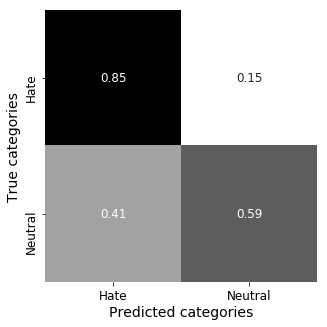

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

confusion_matrix = confusion_matrix(Y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Neutral']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [17]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 65.46052631578947 %
neg_acc 75.0728862973761 %


Parameter tuning